In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import time
import importlib
from os.path import isfile
from sklearn.model_selection import train_test_split
import torchvision.transforms as tfs
from sklearn.metrics import accuracy_score

# import utils file
spec = importlib.util.spec_from_file_location('utils', 'utils.py')
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

In [3]:
# Load and split data

def get_train_test_groups(section, morpho_feats):
    k = 5
    def norm_group(groups):
        new_groups = [ [[] for _ in range(k)] for __ in range(len(groups)) ]
        for i_k in range(k):
            vals = []
            for i_type in range(len(groups)):
                vals.append( groups[i_type][i_k] )
            vals = np.concatenate(vals,axis=0)
            mean_vals = np.mean(vals,axis=0)[np.newaxis,:]
            std_vals = np.std(vals,axis=0)[np.newaxis,:]
    
            for i_type in range(len(groups)):
                new_groups[i_type][i_k] = (groups[i_type][i_k] - mean_vals) / std_vals
        return new_groups
        
    train_mitos, train_bodyIds, test_mitos, test_bodyIds = [], [], [], []
    for i_type, neuron_type in enumerate(utils.analyze_neurons):
        mito_np = np.array([ [] for _ in range(len(morpho_feats)) ]).T
        bodyIds = np.array([], dtype=int)
        for bodyId in utils.neuron_quality_np[utils.neuron_quality_np[:,1] == neuron_type,0]:
            #mito_file = f'segmentations/mito_df/{neuron_type}_{bodyId}_mito_df.csv'
            mito_file = f'saved_mito_df/{neuron_type}_{bodyId}_mito_df.csv'
            if isfile(mito_file):
                # this neuron has a saved mitochondria csv file
                mito_df = pd.read_csv(mito_file)
    
                # node_class_dict takes a section as input about outputs the class integer assigned to that section
                is_in_section = mito_df['class'].to_numpy() == utils.node_class_dict[section]
                if np.any(is_in_section):
                    this_feats = mito_df[np.array(morpho_feats)[:-1]].to_numpy()[is_in_section]
                    mito_radii = ((mito_df['size'].to_numpy() * 3) / (np.pi * 4)) ** (1/3)
                    SBI = np.log10(4 * np.pi * (mito_radii**2) / mito_df['mito SA'].to_numpy())[is_in_section]
                    this_feats = np.append(this_feats, SBI[:,np.newaxis], axis=1)
                    mito_np = np.append(mito_np, this_feats,axis=0)
                    bodyIds = np.append(bodyIds, np.ones(np.sum(is_in_section), dtype=int)*bodyId)
    
        bodyIds_train, bodyIds_test = utils.get_cross_val_groups(np.unique(bodyIds), k)
    
        train_mitos.append( [ mito_np[np.isin(bodyIds, this_bodyIds)] for this_bodyIds in bodyIds_train ] )
        train_bodyIds.append( [ bodyIds[np.isin(bodyIds, this_bodyIds)] for this_bodyIds in bodyIds_train ] )
        test_mitos.append( [ mito_np[np.isin(bodyIds, this_bodyIds)] for this_bodyIds in bodyIds_test ] )
        test_bodyIds.append( [ bodyIds[np.isin(bodyIds, this_bodyIds)] for this_bodyIds in bodyIds_test ] )
    
    train_mitos = norm_group(train_mitos)
    test_mitos = norm_group(test_mitos)
    return train_mitos, train_bodyIds, test_mitos, test_bodyIds

In [133]:
# Hyperparameters

LEARNING_RATE = 1e-2
DROPOUT = 0
combine_mitos = False
epochs=300
nbatches = 25
MODEL_NAME = f"32-{DROPOUT}-{LEARNING_RATE}-leaky_relu-nbatch{nbatches}-epochs{epochs}" # noise-std.05-no2ndSoftMax-


On epoch 0 of 300  |  0.0 minutes
Loss: 36095.53992; train accuracy: 0.33681; test accuracy: 0.23737
On epoch 100 of 300  |  0.63 minutes
Loss: 32723.4307; train accuracy: 0.73875; test accuracy: 0.28148
On epoch 200 of 300  |  1.26 minutes
Loss: 32607.3912; train accuracy: 0.75993; test accuracy: 0.26614


In [ ]:
# Architecture Configuration

np.random.seed(11)

class FFNet(nn.Module):
    def __init__(self, num_classes=len(utils.analyze_neurons), init_dim = None):
        super().__init__()

        # BEST 32-64 (relu, dropout 0.4, LR 1e-3)
        
        # init_dim ~16
        # num_classes ~8

        # Reduced dropout rate
        p = DROPOUT
        
        # Adjusted layer dimensions and removed excessive depth
        self.fc1 = nn.Linear(init_dim, 32)
        self.drop1 = nn.Dropout(p=p)
        # self.pool1 = nn.MaxPool1d(2)
        self.batch1 = nn.BatchNorm1d(32)
        self.act1 = nn.LeakyReLU()
        
        # self.fc2 = nn.Linear(32, 12)        
        # self.drop2 = nn.Dropout(p=p)
        # self.batch2 = nn.BatchNorm1d(12)
        # # self.pool2 = nn.MaxPool1d(4, 2)
        # self.act2 = nn.LeakyReLU()

        # self.fc3 = nn.Linear(12, 32)
        # self.drop3 = nn.Dropout(p=p)
        # self.batch3 = nn.BatchNorm1d(32)
        # # self.pool3 = nn.MaxPool1d(4, 2)
        # self.act3 = nn.LeakyReLU()

        # self.fc4 = nn.Linear(64, 128)
        # self.drop4 = nn.Dropout(p=p)
        # self.batch4 = nn.BatchNorm1d(128)
        # # self.pool3 = nn.MaxPool1d(4, 2)
        # self.act4 = nn.LeakyReLU()

                
        # self.fc5 = nn.Linear(128, 64)
        # self.drop5 = nn.Dropout(p=p)
        # self.act5 = nn.LeakyReLU()
        # self.batch5 = nn.BatchNorm1d(64)
        
        # self.fc6 = nn.Linear(32, 32)
        # self.drop6 = nn.Dropout(p=p)
        # self.act6 = nn.LeakyReLU()
        # self.batch6 = nn.BatchNorm1d(32)


        # self.fc4 = nn.Linear(32, 32)
        # self.drop4 = nn.Dropout(p=p)
        # self.act4 = nn.LeakyReLU()


        self.fc10 = nn.Linear(32, num_classes)
        
        
    def forward(self, x_in):
        
        # Using tanh activation for hidden layers
        x = self.drop1(x_in)
        x = self.act1(self.fc1(x))
        x = self.drop1(x)
        # x = self.pool1(x)
        x = self.batch1(x)

        # x = self.act2(self.fc2(x))
        # x = self.drop2(x)
        # # x = self.pool2(x)
        # x = self.batch2(x)

        # # # noise = np.random.normal(loc=0, scale=STDDEV, size=x_in.shape).astype(np.float32)
        # # # x_skip1 = x_in + torch.from_numpy(noise)

        # x = self.act3(self.fc3(x)) # (torch.cat([x, x_in], 1)))
        # # x = self.drop3(x)
        # # x = self.pool3(x)
        # x = self.batch3(x)

        # # noise = np.random.normal(loc=0, scale=STDDEV, size=x_in.shape).astype(np.float32)
        # # x_skip2 = x_in + torch.from_numpy(noise)
        
        # x = self.act4(self.fc4(x))
        # x = self.drop4(x)
        # x = self.batch4(x)

        # x = self.act5(self.fc5(x))
        # # x = self.drop5(x)
        # x = self.batch5(x)
        
        # x = self.act6(self.fc6(x))
        # x = self.drop6(x)
        # x = self.batch6(x)

        
        # x = self.pool3(torch.cat((x_in, x)))
        # x = self.act4(self.fc4(x))
        # x = self.drop4(x)

        # No activation before softmax in classification layer
        logits = self.fc10(x)
        x = F.log_softmax(logits, dim=-1)
        return x



In [ ]:

# Prepare Data

transform_test = tfs.Compose([
    tfs.ToTensor()
])

morpho_feats = []
morpho_feats.append( 'size' )
morpho_feats.append( 'mito SA' )
morpho_feats.append( 'mito CA' )
morpho_feats.append( 'convex hull compactness' )
morpho_feats.append( 'PC1 Length' )
morpho_feats.append( 'PC1 inertia moment' )
morpho_feats.append( 'PC1 symmetry' )
morpho_feats.append( 'PC2 Length' )
morpho_feats.append( 'PC2 inertia moment' )
morpho_feats.append( 'PC2 symmetry' )
morpho_feats.append( 'PC3 Length' )
morpho_feats.append( 'PC3 inertia moment' )
morpho_feats.append( 'PC3 symmetry' )
morpho_feats.append( 'mito diameter' )
morpho_feats.append( 'length along skeleton' )
morpho_feats.append( 'SBI' )

i_k = 0

section = 'axon'
new_size = np.load(f'presaved_data/{section}_biggest_size.npy')

train_mitos, train_bodyIds, test_mitos, test_bodyIds = get_train_test_groups(section, morpho_feats)

if combine_mitos:
    sample_weights = torch.Tensor([ 1/len(np.unique(np.concatenate(train_bodyIds[i_type]))) for i_type in range(len(utils.analyze_neurons)) ])
else:
    sample_weights = torch.Tensor([ 1/(len(train_mitos[i_type][0])+len(test_mitos[i_type][0])) for i_type in range(len(utils.analyze_neurons)) ])
    #sample_weights = torch.Tensor([ utils.get_sample_weight(neuron_type, section) for neuron_type in utils.analyze_neurons ])



In [ ]:
# Initialize and Train Model

model = FFNet(init_dim = len(morpho_feats)) 
criterion = nn.CrossEntropyLoss(weight = sample_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 1e-6)

train_loss_list, train_acc_list = [], []
test_accs = []
t0 = time.time()
for i in range(epochs):
    if (i % 100) == 0:
        print(f'On epoch {i} of {epochs}  |  {np.round((time.time()-t0)/60,decimals=2)} minutes')
    
    train_loss_epoch = 0
    y_true_arr, y_pred_arr = [], []
    
    all_batch_bodyIds = [ utils.get_batches(np.unique(train_bodyIds[i_type][i_k]), nbatches) for i_type in range(len(utils.analyze_neurons)) ]

    all_type_mitos = [ [ train_mitos[i_type][i_k][np.isin(train_bodyIds[i_type][i_k], all_batch_bodyIds[i_type][i_batch])] for i_batch in range(nbatches) ] for i_type in range(len(utils.analyze_neurons)) ]
    all_type_bodyIds = [ [ train_bodyIds[i_type][i_k][np.isin(train_bodyIds[i_type][i_k], all_batch_bodyIds[i_type][i_batch])] for i_batch in range(nbatches) ] for i_type in range(len(utils.analyze_neurons)) ]
    #assert False
    #all_type_mitos = [ utils.get_batches(all_train[i_type][i_k], nbatches) for i_type in range(len(utils.analyze_neurons)) ]
    
    all_xs = []
    train_loss_epoch = 0
    all_pred, all_true = [], []

    model.train()
    
    for i_batch in range(nbatches):
        x = torch.Tensor(np.concatenate([ all_type_mitos[i_type][i_batch] for i_type in range(len(utils.analyze_neurons)) ], axis=0))

        # Augment with Gaussian Noise
        # STDDEV = 0.01
        # noise = np.random.normal(loc=0, scale=STDDEV, size=x.shape).astype(np.float32)
        # x = x + torch.from_numpy(noise)
        
        this_train_ids = [ np.ones(len(all_type_mitos[i_type][i_batch]))*i_type for i_type in range(len(utils.analyze_neurons)) ]

        combine_ids = torch.Tensor(np.concatenate([ all_type_bodyIds[i_type][i_batch] for i_type in range(len(utils.analyze_neurons)) ], axis=0))
        if combine_mitos:
            
            this_train_ids = torch.LongTensor(np.concatenate(this_train_ids,axis=0))
            
            this_y_pred = model.forward(x)
            y_pred, train_ids = [], []
            for id in np.unique(combine_ids):
                y_pred.append( torch.mean(this_y_pred[ combine_ids == id ],axis=0)[np.newaxis,:] )
                train_ids.append( this_train_ids[ np.where(combine_ids == id)[0][0] ] )
            y_pred = torch.concat(y_pred,axis=0)
            train_ids = torch.LongTensor(train_ids)

            all_pred.append( torch.argmax(y_pred, dim=1)  )
            all_true.append(train_ids)
        else:
            train_ids = torch.LongTensor(np.concatenate(this_train_ids,axis=0))
            y_pred = model.forward(x)
            
            for id in np.unique(combine_ids): 
                all_pred.append( np.argmax( np.mean(y_pred.detach().numpy()[ np.where(id == combine_ids)[0] ], axis=0) ) )
                all_true.append( train_ids[ np.where(combine_ids == id)[0][0] ] )
                
        loss = criterion(y_pred, train_ids) # L1: + sum(p for p in model.parameters())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss_epoch += loss.detach().numpy() * len(train_ids)
        
        
    train_loss_list.append(train_loss_epoch)
    all_true = torch.cat(all_true,dim=0) if combine_mitos else torch.LongTensor(all_true)
    all_pred = torch.cat(all_pred,dim=0) if combine_mitos else torch.LongTensor(all_pred)
    acc = accuracy_score(all_true, all_pred)
    train_acc_list.append(acc)

    model.eval()
    with torch.no_grad():
        x = torch.Tensor(np.concatenate([ test_mitos[i_type][i_k] for i_type in range(len(utils.analyze_neurons)) ],axis=0))
        
        if combine_mitos:
            combine_ids = torch.Tensor(np.concatenate([ test_bodyIds[i_type][i_k] for i_type in range(len(utils.analyze_neurons)) ],axis=0))
        else:
            combine_ids = torch.arange(len(x))
        
        this_y = torch.LongTensor(np.concatenate([ np.ones(len(test_mitos[i_type][i_k]))*i_type for i_type in range(len(utils.analyze_neurons)) ],axis=0))
        #y = [ np.ones(len(all_test[i_type]))*i_type for i_type in range(len(utils.analyze_neurons)) ]
        #y = torch.LongTensor(np.concatenate(y,axis=0))
        
        this_y_pred = model.forward(x)
        y_pred, y = [], []
        for id in np.unique(combine_ids):
            y_pred.append( torch.mean(this_y_pred[ combine_ids == id ],axis=0)[np.newaxis,:] )
            y.append( this_y[ np.where(combine_ids == id)[0][0] ] )
        y_pred = torch.concat(y_pred,axis=0)
        y = torch.LongTensor(y)
        test_acc = accuracy_score(y, torch.argmax(y_pred,axis=1))
        test_accs.append(test_acc)
        #print(f'Test Accuracy = {}')

    if (i % 100) == 0: print(f"Loss: {round(train_loss_epoch, 5)}; train accuracy: {round(acc, 5)}; test accuracy: {round(test_acc, 5)}")



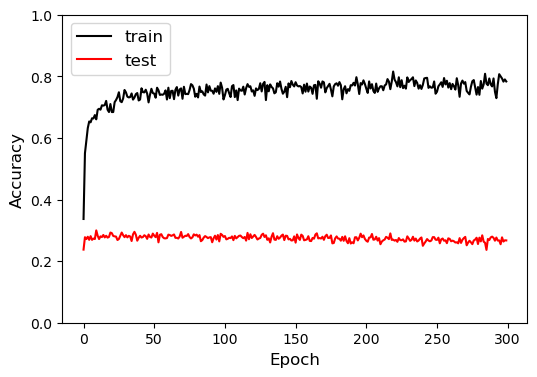

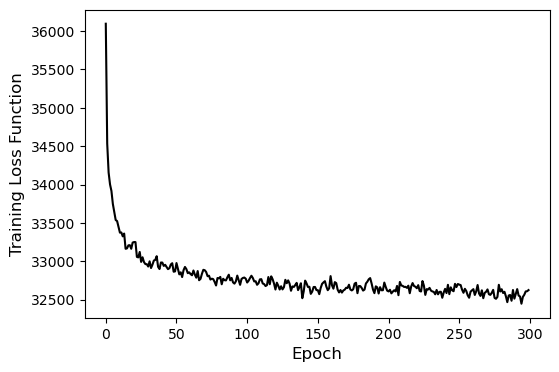

In [134]:
# Plot and save train/test accuracy and Loss

fig = plt.figure(figsize=(6,4))
fontsize=12
plt.plot(np.arange(len(train_acc_list)), train_acc_list, color = 'k', label = 'train')
plt.plot(np.arange(len(test_accs)), test_accs, color = 'r', label = 'test')
plt.ylabel('Accuracy', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylim([0,1])
plt.savefig(f"./simple_feedforward_plots/{MODEL_NAME}_Acc.png")
plt.show()


fig = plt.figure(figsize=(6,4))
fontsize=12
plt.plot(np.arange(len(train_loss_list)), train_loss_list, color = 'k')
plt.ylabel('Training Loss Function', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.savefig(f"./simple_feedforward_plots/{MODEL_NAME}_Loss.png")
plt.show()


In [135]:
# Test the trained network; get confusion matrix

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

num_classes = 8

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():

        # Grab test data
        x = torch.Tensor(np.concatenate([ test_mitos[i_type][i_k] for i_type in range(len(utils.analyze_neurons)) ],axis=0))
    
        # Reconstruct test set
        if combine_mitos:
            combine_ids = torch.Tensor(np.concatenate([ test_bodyIds[i_type][i_k] for i_type in range(len(utils.analyze_neurons)) ],axis=0))
        else:
            combine_ids = torch.arange(len(x))
        
        this_y = torch.LongTensor(np.concatenate([ np.ones(len(test_mitos[i_type][i_k]))*i_type for i_type in range(len(utils.analyze_neurons)) ],axis=0))
        #y = [ np.ones(len(all_test[i_type]))*i_type for i_type in range(len(utils.analyze_neurons)) ]
        #y = torch.LongTensor(np.concatenate(y,axis=0))
        
        this_y_pred = model.forward(x)
        y_pred, y = [], []
        for id in np.unique(combine_ids):
            y_pred.append( torch.mean(this_y_pred[ combine_ids == id ],axis=0)[np.newaxis,:] )
            y.append( this_y[ np.where(combine_ids == id)[0][0] ] )
        y_pred = torch.concat(y_pred,axis=0)
        y = torch.LongTensor(y)
        # test_accs.append(accuracy_score(y, torch.argmax(y_pred,axis=1)))

    
        labels = y
        predicted = torch.argmax(y_pred,axis=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)


Normalized confusion matrix


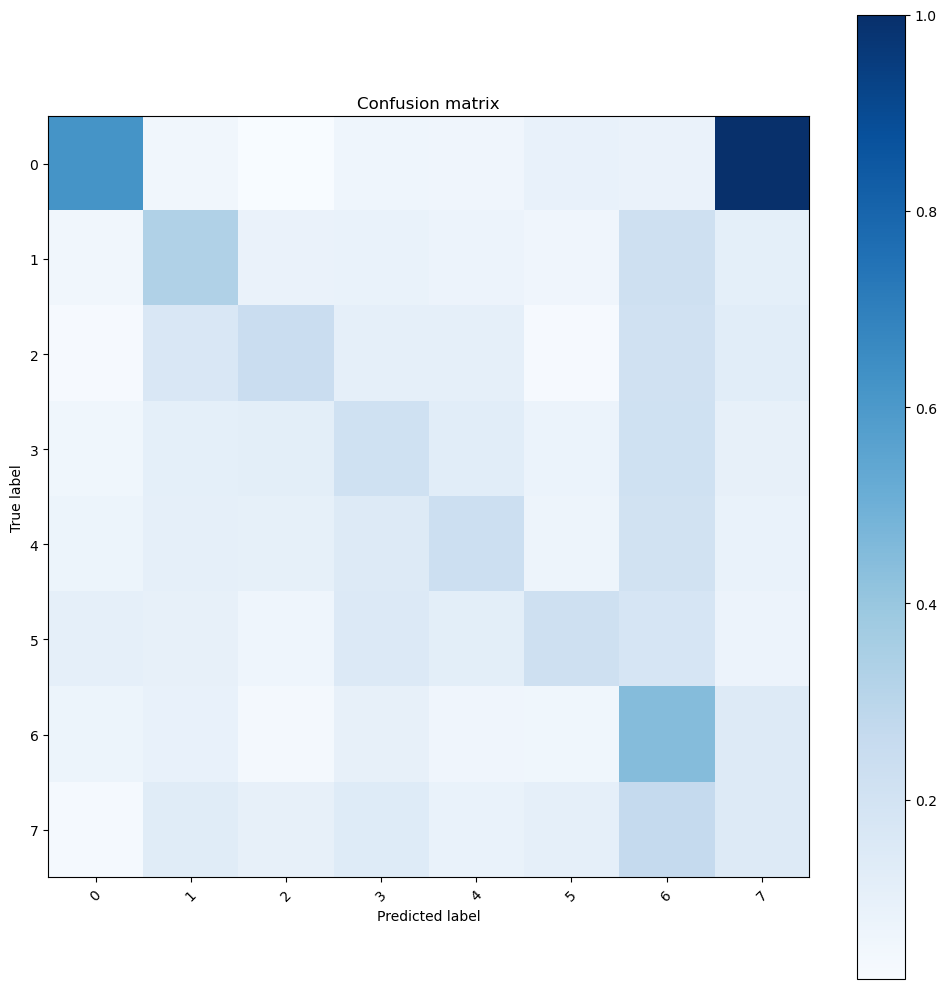

In [136]:
# Plot and save the confusion matrix

import seaborn as sns

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=range(num_classes), normalize=True)
plt.savefig(f"./simple_feedforward_plots/{MODEL_NAME}_CM.jpg")
plt.show()



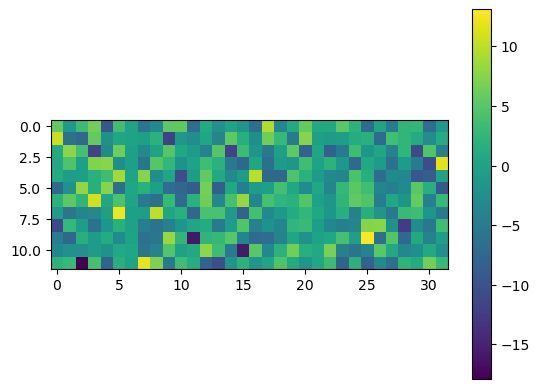

In [119]:
# Plot 2nd Layer weights

plt.imshow(model.fc2.weight.detach().numpy())
plt.colorbar()
plt.show()

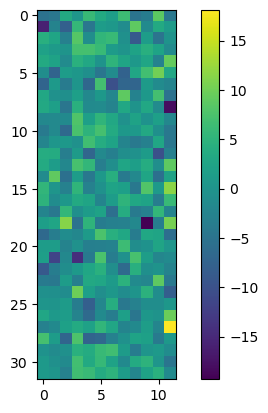

In [120]:
# Plot 3rd Layer weights (if applicable)

plt.imshow(model.fc3.weight.detach().numpy())
plt.colorbar()
plt.show()

In [121]:
# Plot 3rd Layer weights (if applicable)

plt.imshow(model.fc5.weight.detach().numpy())
plt.colorbar()
plt.show()

AttributeError: 'FFNet' object has no attribute 'fc5'